In [331]:
import re
import pandas as pd
import uncertainties as un
import uncertainties.unumpy as unp
import numpy as np
import matplotlib.pyplot as plt

idx = pd.IndexSlice

plt.rcParams['axes.labelsize'] = 'large'
nom = unp.nominal_values
std = unp.std_devs

from latools.helpers.stat_fns import gauss_weighted_stats

# Load Data

In [332]:
# read data
nd = pd.read_csv('data/raw_Neptune_stripped.csv')
# parse datetime
nd.loc[:, 'datetime'] = pd.to_datetime(nd.loc[:, 'Date'] + ' ' + nd.loc[:, 'Time'], format='%d/%m/%y %H:%M:%S')

# calculate minute timescale for each run
nd.loc[:, 'run_minutes'] = 0
for k, g in nd.groupby('Run'):
    nd.loc[nd.Run == k, 'run_minutes'] = (g.datetime - g.datetime.min()).dt.total_seconds() / 60

In [333]:
iblank = nd.Sample == 'Blank'
iwash = nd.Sample == 'Wash'
iLSVEC = nd.Sample.str.contains('SVEC')
iext = nd.Sample.str.contains('ext')
isample = ~(iblank ^ iwash ^ iLSVEC ^ iext)

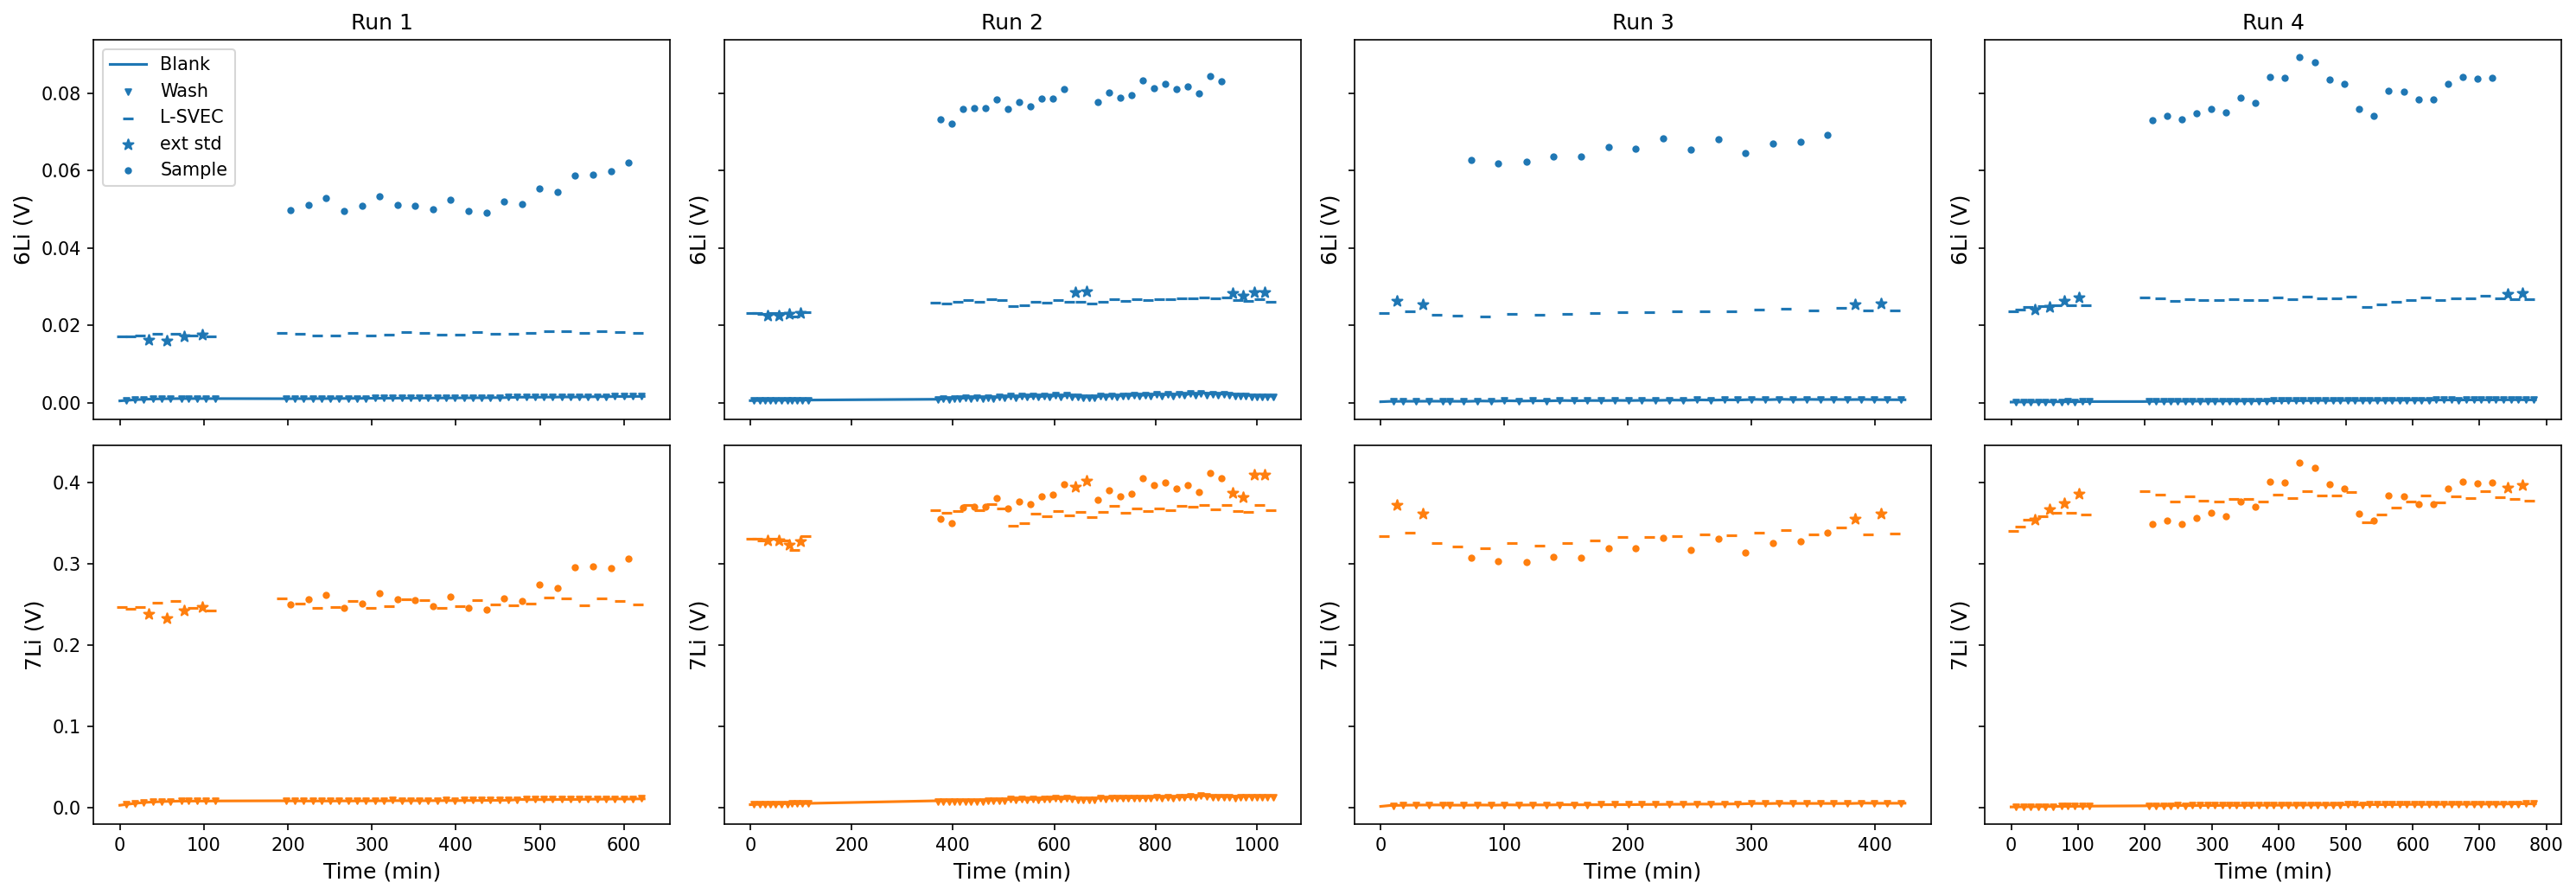

In [334]:
c6Li = 'C0'
c7Li = 'C1'
crLi = 'C2'
xvar = 'run_minutes'

nruns = int(nd.Run.max())

r_plot = [1,2,3,4]
nruns = len(r_plot)

fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

for r in range(1, nruns + 1):
    if r not in r_plot:
        continue
    
    snd = nd.loc[nd.Run == r]
    ax6, ax7 = axs[:, r-1]

    ax6.plot(snd.loc[iblank, xvar], snd.loc[iblank, '6Li'], c=c6Li, label='Blank')
    ax7.plot(snd.loc[iblank, xvar], snd.loc[iblank, '7Li'], c=c7Li)

    ax6.scatter(snd.loc[iwash, xvar], snd.loc[iwash, '6Li'], c=c6Li, s=10, marker='v', label='Wash')
    ax7.scatter(snd.loc[iwash, xvar], snd.loc[iwash, '7Li'], c=c7Li, s=10, marker='v')

    ax6.scatter(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '6Li'], c=c6Li, marker='_', label='L-SVEC')
    ax7.scatter(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '7Li'], c=c7Li, marker='_')

    ax6.scatter(snd.loc[iext, xvar], snd.loc[iext, '6Li'], c=c6Li, marker='*', label='ext std')
    ax7.scatter(snd.loc[iext, xvar], snd.loc[iext, '7Li'], c=c7Li, marker='*')
    
    ax6.scatter(snd.loc[isample, xvar], snd.loc[isample, '6Li'], c=c6Li, marker='.', label='Sample')
    ax7.scatter(snd.loc[isample, xvar], snd.loc[isample, '7Li'], c=c7Li, marker='.')

    ax6.set_ylabel('6Li (V)')
    ax7.set_ylabel('7Li (V)')
    
    ax6.set_title('Run {}'.format(r))
    ax7.set_xlabel('Time (min)')

axs[0, 0].legend()
    
fig.tight_layout()

# Blank Correction

In [444]:
# nd.loc[:, 'c6Li'] = pd.Series(dtype='object')
# nd.loc[:, 'c7Li'] = pd.Series(dtype='object')

# nd.loc[:, 'c7Li/c6Li'] = pd.Series(dtype='object')
# nd.loc[:, 'alpha_Sample-LSVEC'] = pd.Series(dtype='object')

# for r, g in nd.groupby('Run'):
#     siblank = g.Sample == 'Blank'
#     siwash = g.Sample == 'Wash'
#     siLSVEC = g.Sample.str.contains('SVEC')
#     sisample = ~(siblank ^ siwash ^ siLSVEC)

#     # blank correct LSVEC - subtract blank before
#     LSVEC_indices = g.loc[siLSVEC].index
#     LSVEC_blank_indices = LSVEC_indices - 1

#     nd.loc[LSVEC_indices, 'c6Li'] = nd.loc[LSVEC_indices, '6Li'] - nd.loc[LSVEC_blank_indices, '6Li'].values
#     nd.loc[LSVEC_indices, 'c7Li'] = nd.loc[LSVEC_indices, '7Li'] - nd.loc[LSVEC_blank_indices, '7Li'].values

#     nd.loc[LSVEC_indices, 'c7Li/c6Li'] = nd.loc[LSVEC_indices, 'c7Li'] / nd.loc[LSVEC_indices, 'c6Li']

#     # blank correct samples - subtract blanks associated with bracketing LSVECs
#     sample_indices = g.loc[sisample].index

#     for i in sample_indices:
#         # identify bracketing LSVECs
#         bracketing_LSVECs = LSVEC_indices[np.argsort(abs(LSVEC_indices - i))[:2]]
#         bracketing_blanks = bracketing_LSVECs - 1
        
#         nd.loc[i, 'c6Li'] = nd.loc[i, '6Li'] - un.ufloat(nd.loc[bracketing_blanks, '6Li'].mean(), nd.loc[bracketing_blanks, '6Li'].std())
#         nd.loc[i, 'c7Li'] = nd.loc[i, '7Li'] - un.ufloat(nd.loc[bracketing_blanks, '7Li'].mean(), nd.loc[bracketing_blanks, '7Li'].std())

#         nd.loc[i, 'c7Li/c6Li'] = nd.loc[i, 'c7Li'] / nd.loc[i, 'c6Li']
        
#         # calculate alpha: divide by bracketing LSVEC ratios
#         nd.loc[i, 'alpha_Sample-LSVEC'] = nd.loc[i, 'c7Li/c6Li'] / un.ufloat(nd.loc[bracketing_LSVECs, 'c7Li/c6Li'].mean(), nd.loc[bracketing_LSVECs, 'c7Li/c6Li'].std())

# nd.loc[:, 'delta_Sample-LSVEC'] = (nd.loc[:, 'alpha_Sample-LSVEC'] - 1) * 1000

# nd_shambles = nd.copy()

In [494]:
nd.loc[:, 'c6Li'] = pd.Series(dtype='object')
nd.loc[:, 'c7Li'] = pd.Series(dtype='object')

nd.loc[:, 'c7Li/c6Li'] = pd.Series(dtype='object')
nd.loc[:, 'alpha_Sample-LSVEC'] = pd.Series(dtype='object')

for r, g in nd.groupby('Run'):
    siblank = g.Sample == 'Blank'
    siwash = g.Sample == 'Wash'
    siLSVEC = g.Sample.str.contains('SVEC')
    sisample = ~(siblank ^ siwash ^ siLSVEC)

    # blank correct LSVEC - subtract blank before
    sample_indices = g.loc[sisample].index

    LSVEC_indices = g.loc[siLSVEC].index
    LSVEC_blank_indices = LSVEC_indices - 1

    for i in LSVEC_indices:
        pre_offset = 1
        while g.loc[i - pre_offset, 'Sample'] != 'Blank':
            pre_offset += 1
                
        post_offset = 1
        while g.loc[i + post_offset, 'Sample'] != 'Blank':
            post_offset += 1
        
        blank_indices = [i - pre_offset, i + post_offset]
        # blank_indices = [i - pre_offset]
        
        # nd.loc[i, 'c6Li'] = nd.loc[i, '6Li'] - un.ufloat(nd.loc[blank_indices, '6Li'].mean(), nd.loc[blank_indices, '6Li'].std() / np.sqrt(2))
        # nd.loc[i, 'c7Li'] = nd.loc[i, '7Li'] - un.ufloat(nd.loc[blank_indices, '7Li'].mean(), nd.loc[blank_indices, '7Li'].std() / np.sqrt(2))

        nd.loc[i, 'c6Li'] = nd.loc[i, '6Li'] - nd.loc[blank_indices, '6Li'].mean()
        nd.loc[i, 'c7Li'] = nd.loc[i, '7Li'] - nd.loc[blank_indices, '7Li'].mean()


        nd.loc[i, 'c7Li/c6Li'] = nd.loc[i, 'c7Li'] / nd.loc[i, 'c6Li']
    
    # nd.loc[LSVEC_indices, 'c6Li'] = nd.loc[LSVEC_indices, '6Li'] - nd.loc[LSVEC_blank_indices, '6Li'].values
    # nd.loc[LSVEC_indices, 'c7Li'] = nd.loc[LSVEC_indices, '7Li'] - nd.loc[LSVEC_blank_indices, '7Li'].values

    # nd.loc[LSVEC_indices, 'c7Li/c6Li'] = nd.loc[LSVEC_indices, 'c7Li'] / nd.loc[LSVEC_indices, 'c6Li']

    # blank correct samples - subtract blanks associated with bracketing LSVECs
    
    for i in sample_indices:
        pre_offset = 1
        while g.loc[i - pre_offset, 'Sample'] != 'Blank':
            pre_offset += 1
                
        post_offset = 1
        while g.loc[i + post_offset, 'Sample'] != 'Blank':
            post_offset += 1
        
        blank_indices = [i - pre_offset, i + post_offset]
        # blank_indices = [i - pre_offset]
        
        # nd.loc[i, 'c6Li'] = nd.loc[i, '6Li'] - un.ufloat(nd.loc[blank_indices, '6Li'].mean(), nd.loc[blank_indices, '6Li'].std() / np.sqrt(2))
        # nd.loc[i, 'c7Li'] = nd.loc[i, '7Li'] - un.ufloat(nd.loc[blank_indices, '7Li'].mean(), nd.loc[blank_indices, '7Li'].std() / np.sqrt(2))

        nd.loc[i, 'c6Li'] = nd.loc[i, '6Li'] - nd.loc[blank_indices, '6Li'].mean()
        nd.loc[i, 'c7Li'] = nd.loc[i, '7Li'] - nd.loc[blank_indices, '7Li'].mean()

        nd.loc[i, 'c7Li/c6Li'] = nd.loc[i, 'c7Li'] / nd.loc[i, 'c6Li']
        
        # calculate alpha: divide by bracketing LSVEC ratios
        bracketing_LSVECs = LSVEC_indices[np.argsort(abs(LSVEC_indices - i))[:2]]
        
        # if LSVEC are more than 0.1% different, use the one before the sample
        v = unp.nominal_values(nd.loc[bracketing_LSVECs, 'c7Li/c6Li'].values)
        if v.std() / v.mean() > 0.001:
            bracketing_LSVECs = [bracketing_LSVECs[0]]
            v = unp.nominal_values(nd.loc[bracketing_LSVECs, 'c7Li/c6Li'])
        
        nd.loc[i, 'alpha_Sample-LSVEC'] = nd.loc[i, 'c7Li/c6Li'] / nd.loc[bracketing_LSVECs, 'c7Li/c6Li'].values.mean()

        
        # nd.loc[i, 'alpha_Sample-LSVEC'] = nd.loc[i, 'c7Li/c6Li'] / un.ufloat(v.mean(), v.std() / np.sqrt(2))
                
        # nd.loc[i, 'alpha_Sample-LSVEC'] = nd.loc[i, 'c7Li/c6Li'] / unp.nominal_values(nd.loc[bracketing_LSVECs, 'c7Li/c6Li'].values).mean()
        
        # if nd.loc[i, 'alpha_Sample-LSVEC'].std_dev() > 0.001:
        #     print(nd.loc[[i], ['Sample', 'c6Li', 'c7Li', 'c7Li/c6Li', 'alpha_Sample-LSVEC']])
        #     print(v.std() / v.mean())
        #     print()
            
        #     plt.scatter(nd.loc[LSVEC_indices, 'run_minutes'], unp.nominal_values(nd.loc[LSVEC_indices, 'c7Li/c6Li']))
        #     plt.scatter(nd.loc[bracketing_LSVECs, 'run_minutes'], unp.nominal_values(nd.loc[bracketing_LSVECs, 'c7Li/c6Li']), color='k', marker='x', s=50)

nd.loc[:, 'delta_Sample-LSVEC'] = (nd.loc[:, 'alpha_Sample-LSVEC'] - 1) * 1000

nd_mads = nd.copy()

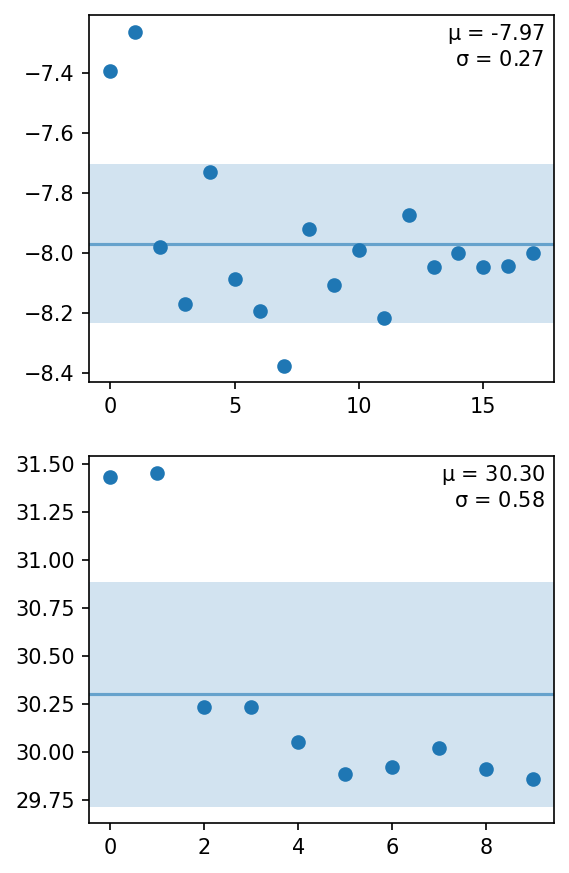

In [496]:
fig, axs = plt.subplots(2, 1, figsize=[4, 7])

ext = nd.loc[iext].sort_values('datetime')

for ax, exstd in zip(axs, ['6Li ext std', '7Li ext std']):
    ind = ext.Sample == exstd
    x = np.arange(sum(ind))
    ax.errorbar(x, nom(ext.loc[ind, 'delta_Sample-LSVEC']), std(ext.loc[ind, 'delta_Sample-LSVEC']), lw=0, elinewidth=1, marker='o')
    
    mu = np.mean(nom(ext.loc[ind, 'delta_Sample-LSVEC']))
    err = np.std(nom(ext.loc[ind, 'delta_Sample-LSVEC']))
    ax.axhline(mu, alpha=0.6)
    ax.axhspan(mu - err, mu + err, alpha=0.2)
    
    ax.text(.98, .98, f'$\mu$ = {mu:.2f}\n$\sigma$ = {err:.2f}', transform=ax.transAxes, va='top', ha='right')

In [449]:
# nd.loc[:, 'c6Li'] = 0
# nd.loc[:, 'c7Li'] = 0

# r_plot = [1,2,3,4]
# nruns = len(r_plot)

# fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

# for r, g in nd.groupby('Run'):
#     siblank = g.Sample == 'Blank'
#     siwash = g.Sample == 'Wash'
#     sisample = ~(siblank ^ siwash)
    
#     # isolate blanks
#     sample_indices = g.loc[sisample].index
#     # pre_blank = g.loc[sample_indices - 1, ['6Li', '7Li']]
    
#     pre_blank = []
#     post_blank = []
#     for i in sample_indices:
#         pre_offset = 1
#         while g.loc[i - pre_offset, 'Sample'] != 'Blank':
#             pre_offset += 1
#         pre_blank.append(g.loc[i - pre_offset, ['6Li', '7Li']])
        
#         post_offset = 1
#         while g.loc[i + post_offset, 'Sample'] != 'Blank':
#             post_offset += 1
#         post_blank.append(g.loc[i + post_offset, ['6Li', '7Li']])

#     pre_blank = pd.DataFrame(pre_blank)
#     post_blank = pd.DataFrame(post_blank)
    
#     mu_bkg = (pre_blank.values + post_blank.values) / 2
    
#     if r in r_plot:
#         ax6, ax7 = axs[:, r-1]
#         ax6.scatter(g.loc[siblank, 'run_minutes'], g.loc[siblank, '6Li'], s=5, label='blank')
#         ax6.scatter(g.loc[sisample, 'run_minutes'], g.loc[sisample, '6Li'], s=5, label='sample/LSVEC')
        
#         ax7.scatter(g.loc[siblank, 'run_minutes'], g.loc[siblank, '7Li'], s=5)
#         ax7.scatter(g.loc[sisample, 'run_minutes'], g.loc[sisample, '7Li'], s=5)
        
#         ax6.set_ylabel('6Li (V)')
#         ax7.set_ylabel('7Li (V)')
        
#         ax6.set_title('Run {}'.format(r))
#         ax7.set_xlabel('Time (min)')
        
#         ax6.set_yscale('log')
#         ax7.set_yscale('log')

#     nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c6Li'] = g.loc[sisample, '6Li'] - mu_bkg[:,0]
#     nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c7Li'] = g.loc[sisample, '7Li'] - mu_bkg[:,1]

In [450]:
# nd.loc[:, 'c6Li'] = 0
# nd.loc[:, 'c7Li'] = 0

# r_plot = [1,2,3,4]
# nruns = len(r_plot)

# fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

# for r, g in nd.groupby('Run'):
#     siblank = g.Sample == 'Blank'
#     siwash = g.Sample == 'Wash'
#     sisample = ~(siblank ^ siwash)
    
#     # isolate blanks
#     sample_indices = g.loc[sisample].index
#     # pre_blank = g.loc[sample_indices - 1, ['6Li', '7Li']]
    
#     pre_blank = []
#     post_blank = []
#     for i in sample_indices:
#         pre_offset = 1
#         while g.loc[i - pre_offset, 'Sample'] != 'Blank':
#             pre_offset += 1
#         pre_blank.append(g.loc[i - pre_offset, ['6Li', '7Li']])
        
#         post_offset = 1
#         while g.loc[i + post_offset, 'Sample'] != 'Blank':
#             post_offset += 1
#         post_blank.append(g.loc[i + post_offset, ['6Li', '7Li']])

#     pre_blank = pd.DataFrame(pre_blank)
#     post_blank = pd.DataFrame(post_blank)
    
#     mu_bkg = (pre_blank.values + post_blank.values) / 2
    
#     if r in r_plot:
#         ax6, ax7 = axs[:, r-1]
#         ax6.scatter(g.loc[siblank, 'run_minutes'], g.loc[siblank, '6Li'], s=5, label='blank')
#         ax6.scatter(g.loc[sisample, 'run_minutes'], g.loc[sisample, '6Li'], s=5, label='sample/LSVEC')
        
#         ax7.scatter(g.loc[siblank, 'run_minutes'], g.loc[siblank, '7Li'], s=5)
#         ax7.scatter(g.loc[sisample, 'run_minutes'], g.loc[sisample, '7Li'], s=5)
        
#         ax6.set_ylabel('6Li (V)')
#         ax7.set_ylabel('7Li (V)')
        
#         ax6.set_title('Run {}'.format(r))
#         ax7.set_xlabel('Time (min)')
        
#         ax6.set_yscale('log')
#         ax7.set_yscale('log')

#     nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c6Li'] = g.loc[sisample, '6Li'] - mu_bkg[:,0]
#     nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c7Li'] = g.loc[sisample, '7Li'] - mu_bkg[:,1]

# # ax6.legend()
# #     nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c6Li'] = g.loc[sisample, '6Li'] - bmean[0]
# #     nd.loc[(nd.Run == r) & ~(iblank ^ iwash), 'c7Li'] = g.loc[sisample, '7Li'] - bmean[1]

In [451]:
# def errscat(x, y, ax=None, **kwargs):
#     if ax is None:
#         ax = plt.gca()
        
#     s = ax.scatter(x, nom(y), **kwargs)
#     ax.errorbar(x, nom(y), std(y), lw=0, elinewidth=1, c=s.get_facecolor()[0])

In [452]:
# r_plot = [1,2,3,4]
# nruns = len(r_plot)

# fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

# for r in range(1, nruns + 1):
#     if r not in r_plot:
#         continue
    
#     snd = nd.loc[nd.Run == r]
#     ax6, ax7 = axs[:, r-1]
    
#     errscat(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, 'c6Li'], ax6, c=c6Li, marker='_', label='L-SVEC')
#     errscat(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, 'c7Li'], ax7, c=c7Li, marker='_')
# #     ax6.scatter(snd.loc[iLSVEC, xvar], nom(snd.loc[iLSVEC, 'c6Li']), c=c6Li, marker='_', label='L-SVEC')
# #     ax7.scatter(snd.loc[iLSVEC, xvar], nom(snd.loc[iLSVEC, 'c7Li']), c=c7Li, marker='_')

#     errscat(snd.loc[iext, xvar], snd.loc[iext, 'c6Li'], ax6, c=c6Li, marker='*', label='ext std')
#     errscat(snd.loc[iext, xvar], snd.loc[iext, 'c7Li'], ax7, c=c7Li, marker='*')
# #     ax6.scatter(snd.loc[iext, xvar], nom(snd.loc[iext, 'c6Li']), c=c6Li, marker='*', label='ext std')
# #     ax7.scatter(snd.loc[iext, xvar], nom(snd.loc[iext, 'c7Li']), c=c7Li, marker='*')
    
#     errscat(snd.loc[isample, xvar], snd.loc[isample, 'c6Li'], ax6, c=c6Li, marker='.', label='Sample')
#     errscat(snd.loc[isample, xvar], snd.loc[isample, 'c7Li'], ax7, c=c7Li, marker='.')
# #     ax6.scatter(snd.loc[isample, xvar], nom(snd.loc[isample, '6Li']), c=c6Li, marker='.', label='Sample')
# #     ax7.scatter(snd.loc[isample, xvar], nom(snd.loc[isample, '7Li']), c=c7Li, marker='.')

#     ax6.set_ylabel('6Li - blank (V)')
#     ax7.set_ylabel('7Li - blank (V)')
    
#     ax6.set_title('Run {}'.format(r))
#     ax7.set_xlabel('Time (min)')

# axs[0, 0].legend()

# fig.tight_layout()

# Ratio Calculation

In [453]:
# nd.loc[~(iblank ^ iwash), '7Li/6Li'] = nd.loc[~(iblank ^ iwash), 'c7Li'] / nd.loc[~(iblank ^ iwash), 'c6Li']

In [454]:
# r_plot = [1,2,3,4]
# nruns = len(r_plot)

# fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 4), sharey='row', sharex='col')

# for r in range(1, nruns + 1):
#     if r not in r_plot:
#         continue
    
#     snd = nd.loc[nd.Run == r]
#     ax = axs[:, r-1]
    
#     errscat(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '7Li/6Li'], ax[0], c=crLi , marker='_', label='L-SVEC')
#     # errscat(snd.loc[iext, xvar], snd.loc[iext, '7Li/6Li'], ax, c=crLi , marker='*', label='ext std')
# #     ax.scatter(snd.loc[iLSVEC, xvar], snd.loc[iLSVEC, '7Li/6Li'], c=crLi , marker='_', label='L-SVEC')
# #     ax.scatter(snd.loc[iext, xvar], snd.loc[iext, '7Li/6Li'], c=crLi , marker='*', label='ext std')
    
#     errscat(snd.loc[isample, xvar], snd.loc[isample, '7Li/6Li'], ax[1], c=crLi, marker='.', label='Sample')
# #     ax.scatter(snd.loc[isample, xvar], snd.loc[isample, '7Li/6Li'], c=crLi, marker='.', label='Sample')

#     ax[0].set_title('Run {}'.format(r))
#     ax[1].set_xlabel('Time (min)')
    

# axs[0].set_ylabel('7Li/6Li (V/V)')
# axs[0].legend()

# fig.tight_layout()

# Standardisation to LSVEC

In [455]:
# nd.loc[:, 'alpha_Sample-LSVEC'] = np.nan

# for r, g in nd.groupby('Run'):
#     siblank = g.Sample == 'Blank'
#     siwash = g.Sample == 'Wash'
#     siLSVEC = g.Sample.str.contains('SVEC')
#     sisample = ~(siblank ^ siwash ^ siLSVEC)
    
#     # isolate LSVEC
#     sample_indices = g.loc[sisample].index
    
#     pre_LSVEC = []
#     post_LSVEC = []
#     for i in sample_indices:
#         pre_offset = 1
#         while g.loc[i - pre_offset, 'Sample'] != 'L-SVEC':
#             pre_offset += 1
#         pre_LSVEC.append(g.loc[i - pre_offset, ['7Li/6Li']])
        
#         post_offset = 1
#         while g.loc[i + post_offset, 'Sample'] != 'L-SVEC':
#             post_offset += 1
#         post_LSVEC.append(g.loc[i + post_offset, ['7Li/6Li']])
        
#     pre_LSVEC = pd.DataFrame(pre_LSVEC)
#     post_LSVEC = pd.DataFrame(post_LSVEC)
    
#     mu_LSVEC = (pre_LSVEC.values + post_LSVEC.values) / 2
#     std_LSVEC = np.std([pre_LSVEC.values, post_LSVEC.values], axis=0)

#     uLSVEC = unp.uarray(mu_LSVEC, std_LSVEC)
    
#     nd.loc[(nd.Run == r) & sisample, 'alpha_Sample-LSVEC'] = g.loc[sisample, '7Li/6Li'] / uLSVEC[0]
# #     nd.loc[(nd.Run == r) & sisample, 'alpha_Sample-LSVEC'] = g.loc[sisample, '7Li/6Li'] / bmean[0]

In [456]:
# for r, g in nd.groupby('Run'):
#     siblank = g.Sample == 'Blank'
#     siwash = g.Sample == 'Wash'
#     siLSVEC = g.Sample.str.contains('SVEC')
#     sisample = ~(siblank ^ siwash ^ siLSVEC)
    
#     # isolate LSVEC
#     sample_indices = g.loc[sisample].index
    
#     pre_LSVEC = []
#     post_LSVEC = []
#     for i in sample_indices:
#         pre_offset = 1
#         while g.loc[i - pre_offset, 'Sample'] != 'L-SVEC':
#             pre_offset += 1
#         pre_LSVEC.append(g.loc[i - pre_offset])
        
#         post_offset = 1
#         while g.loc[i + post_offset, 'Sample'] != 'L-SVEC':
#             post_offset += 1
#         post_LSVEC.append(g.loc[i + post_offset])
    
#     pre_LSVEC = pd.DataFrame(pre_LSVEC)
#     post_LSVEC = pd.DataFrame(post_LSVEC)

# tmp = g.loc[sisample, ['Sample', '7Li/6Li']]
# tmp['pre_LSVEC'] = pre_LSVEC['7Li/6Li'].values
# tmp['post_LSVEC'] = post_LSVEC['7Li/6Li'].values

# tmp['alpha_pre'] = tmp['7Li/6Li'] / tmp['pre_LSVEC']
# tmp['alpha_post'] = tmp['7Li/6Li'] / tmp['post_LSVEC']

# tmp

In [457]:
# blank_fwhm = 100

# nd.loc[:, 'alpha_Sample-LSVEC'] = np.nan

# for r, g in nd.groupby('Run'):
#     siblank = g.Sample == 'Blank'
#     siwash = g.Sample == 'Wash'
#     siLSVEC = g.Sample.str.contains('SVEC')
#     sisample = ~(siblank ^ siwash ^ siLSVEC)

#     bmean, bstd, bse = gauss_weighted_stats(g.loc[siLSVEC, 'run_minutes'].values, 
#                                             nom(g.loc[siLSVEC, '7Li/6Li'].values[:, np.newaxis]), 
#                                             g.loc[sisample, 'run_minutes'].values, blank_fwhm)
#     uLSVEC = unp.uarray(bmean, bstd)
    
#     nd.loc[(nd.Run == r) & sisample, 'alpha_Sample-LSVEC'] = g.loc[sisample, '7Li/6Li'] / uLSVEC[0]
# #     nd.loc[(nd.Run == r) & sisample, 'alpha_Sample-LSVEC'] = g.loc[sisample, '7Li/6Li'] / bmean[0]

In [458]:
# nd.loc[:, 'delta_Sample-LSVEC'] = (nd.loc[:, 'alpha_Sample-LSVEC'] - 1) * 1000

In [459]:
# r_plot = [1,2,3,4]
# nruns = len(r_plot)

# fig, axs = plt.subplots(2, nruns, figsize=(5 * nruns, 7), sharey='row', sharex='col')

# for r in range(1, nruns + 1):
#     if r not in r_plot:
#         continue
#     snd = nd.loc[nd.Run == r]
#     aax, dax = axs[:, r-1]
    
#     # errscat(snd.loc[isample, xvar], snd.loc[isample, 'alpha_Sample-LSVEC'], aax, c=crLi, marker='.')
#     # errscat(snd.loc[isample, xvar], snd.loc[isample, 'delta_Sample-LSVEC'], dax, c=crLi, marker='.')
    
#     errscat(snd.loc[iext, xvar], snd.loc[iext, 'alpha_Sample-LSVEC'], aax, c=crLi, marker='.')
#     errscat(snd.loc[iext, xvar], snd.loc[iext, 'delta_Sample-LSVEC'], dax, c=crLi, marker='.')

#     # aax.scatter(snd.loc[isample, xvar], snd.loc[isample, 'alpha_Sample-LSVEC'], c=crLi, marker='.')
#     # dax.scatter(snd.loc[isample, xvar], snd.loc[isample, 'delta_Sample-LSVEC'], c=crLi, marker='.')

#     aax.set_ylabel('$\\alpha_{Sample-LSVEC}$')
#     dax.set_ylabel('$\\delta_{Sample-LSVEC}$')
    
#     aax.set_title('Run {}'.format(r))
#     dax.set_xlabel('Time (min)')

# fig.tight_layout()

In [460]:
# for k, d in nd.loc[isample, ['Sample','alpha_Sample-LSVEC','delta_Sample-LSVEC']].groupby('Sample'):
#     pass

### External Standards

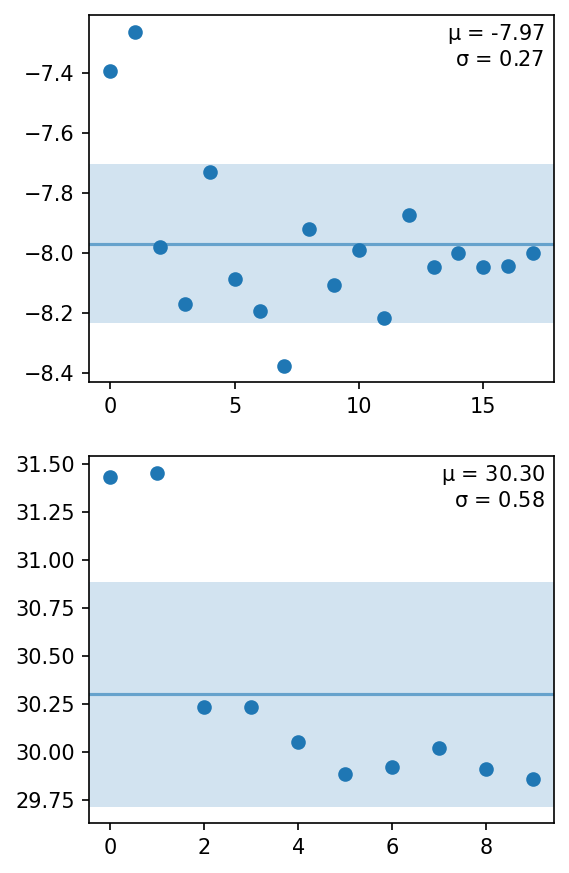

In [498]:
ext = nd.loc[iext]

fig, axs = plt.subplots(2, 1, figsize=[4, 7])

for ax, exstd in zip(axs, ['6Li ext std', '7Li ext std']):
    ind = ext.Sample == exstd
    x = np.arange(sum(ind))
    ax.errorbar(x, nom(ext.loc[ind, 'delta_Sample-LSVEC']), std(ext.loc[ind, 'delta_Sample-LSVEC']), lw=0, elinewidth=1, marker='o')
    
    mu = np.mean(nom(ext.loc[ind, 'delta_Sample-LSVEC']))
    err = np.std(nom(ext.loc[ind, 'delta_Sample-LSVEC']))
    ax.axhline(mu, alpha=0.6)
    ax.axhspan(mu - err, mu + err, alpha=0.2)
    
    ax.text(.98, .98, f'$\mu$ = {mu:.2f}\n$\sigma$ = {err:.2f}', transform=ax.transAxes, va='top', ha='right')

## Think about this

In [499]:
# # correction factors (based on instrumental standard offsets)
# cf = {1: -1,
#       6: -1.2,
#       7: -0.5}

# for group, factor in cf.items():
#     nd.loc[nd.loc[:, 'Run'] == group, 'delta_Sample-LSVEC'] += factor
    
# nd.loc[:, 'alpha_Sample-LSVEC'] = nd.loc[:, 'delta_Sample-LSVEC'] / 1000 + 1

In [500]:
def mean(d):
    return np.mean(d.values)

sam = nd.loc[isample, ['Sample','alpha_Sample-LSVEC','delta_Sample-LSVEC']].groupby('Sample').aggregate([mean, len])

## Format Data for Export

In [526]:
sam_alpha = nd.loc[isample, ['Sample','alpha_Sample-LSVEC', 'Run']].groupby('Sample').aggregate([mean, len])

sam_alpha.loc[:, ('Li_isotopes_alpha_LSVEC', 'solid')] = unp.nominal_values(sam_alpha.loc[:, ('alpha_Sample-LSVEC', 'mean')])
sam_alpha.loc[:, ('Li_isotopes_alpha_LSVEC', 'solid_std')] = unp.std_devs(sam_alpha.loc[:, ('alpha_Sample-LSVEC', 'mean')])
sam_alpha.drop('alpha_Sample-LSVEC', axis=1, inplace=True)

### Isolate Fluids

In [528]:
iliq = sam.index.str.contains('pre') | sam.index.str.contains('post')
isol = ~iliq

experiments = sam.loc[isol].index
solids = sam.loc[isol]
rsolns = sam.loc[iliq]

# parse out pre/post experiment solution measurements
solns = pd.DataFrame(columns=pd.MultiIndex.from_product([sam.columns.levels[0], ['pre', 'post']]))

parse_name = re.compile('(C?[0-9].[0-9]) ?([preost]+)')
for k, r in rsolns.iterrows():
    cond, prepost = parse_name.match(k).groups()
    vals = r.loc[idx[:, 'mean']]

    solns.loc[cond, idx[:, prepost]] = vals.values

In [529]:
for p in ['pre', 'post']:
    solns.loc[:, ('Li_isotopes_alpha_LSVEC', 'fluid_' + p)] = unp.nominal_values(solns.loc[:, ('alpha_Sample-LSVEC', p)])
    solns.loc[:, ('Li_isotopes_alpha_LSVEC', 'fluid_' + p + '_std')] = unp.std_devs(solns.loc[:, ('alpha_Sample-LSVEC', p)])

In [530]:
solns

alpha_Sample-LSVEC           delta_Sample-LSVEC              \
                    pre      post                pre        post   
1.1            0.330427  0.330464        -669.573105 -669.536242   
2.1             0.33051  0.330512        -669.490029 -669.488298   
3.1            0.330536  0.330493        -669.464109 -669.506739   
4.1            0.330495  0.330518        -669.505487 -669.482036   
5.1            0.330654   0.33011        -669.346364 -669.890339   
6.1             0.33017  0.330331        -669.829639 -669.668854   
7.1            0.331258   0.33176         -668.74185 -668.239581   
8.1            0.332317  0.331101        -667.682664 -668.898639   
8.2            0.330783  0.332471        -669.216534 -667.528619   
C1.1           0.330351   0.33041        -669.648687 -669.589562   
C2.1           0.331569  0.331546         -668.43067 -668.453911   
C2.3           0.331843   0.33165        -668.157374 -668.349857   

     Li_isotopes_alpha_LSVEC                                          
                   fluid_pre fluid_pre_std fluid_post fluid_post_std  
1.1                 0.330427           0.0   0.330464            0.0  
2.1                 0.330510           0.0   0.330512            0.0  
3.1                 0.330536           0.0   0.330493            0.0  
4.1                 0.330495           0.0   0.330518            0.0  
5.1                 0.330654           0.0   0.330110            0.0  
6.1                 0.330170           0.0   0.330331            0.0  
7.1                 0.331258           0.0   0.331760            0.0  
8.1                 0.332317           0.0   0.331101            0.0  
8.2                 0.330783           0.0   0.332471            0.0  
C1.1                0.330351           0.0   0.330410            0.0  
C2.1                0.331569           0.0   0.331546            0.0  
C2.3                0.331843           0.0   0.331650            0.0

In [531]:
sam_alpha = sam_alpha.join(solns.loc[:, idx['Li_isotopes_alpha_LSVEC', :]])

In [532]:
sam_alpha.loc[sam_alpha.index.str.contains('pre')]

Run     Li_isotopes_alpha_LSVEC                                    \
          mean len                   solid solid_std fluid_pre fluid_pre_std   
Sample                                                                         
1.1 pre    4.0   2                0.330427       0.0       NaN           NaN   
2.1 pre    4.0   2                0.330510       0.0       NaN           NaN   
3.1 pre    4.0   2                0.330536       0.0       NaN           NaN   
4.1 pre    4.0   2                0.330495       0.0       NaN           NaN   
5.1pre     9.0   2                0.330654       0.0       NaN           NaN   
6.1pre     9.0   2                0.330170       0.0       NaN           NaN   
7.1pre    10.0   2                0.331258       0.0       NaN           NaN   
8.1pre     8.0   2                0.332317       0.0       NaN           NaN   
8.2 pre    7.0   2                0.330783       0.0       NaN           NaN   
C1.1 pre   4.0   2                0.330351       0.0       NaN           NaN   
C2.1 pre   4.0   2                0.331569       0.0       NaN           NaN   
C2.3 pre   7.0   2                0.331843       0.0       NaN           NaN   

                                    
         fluid_post fluid_post_std  
Sample                              
1.1 pre         NaN            NaN  
2.1 pre         NaN            NaN  
3.1 pre         NaN            NaN  
4.1 pre         NaN            NaN  
5.1pre          NaN            NaN  
6.1pre          NaN            NaN  
7.1pre          NaN            NaN  
8.1pre          NaN            NaN  
8.2 pre         NaN            NaN  
C1.1 pre        NaN            NaN  
C2.1 pre        NaN            NaN  
C2.3 pre        NaN            NaN

In [533]:
sam_alpha = sam_alpha.loc[~(sam_alpha.index.str.contains('post') | sam_alpha.index.str.contains('pre'))]

sam_alpha.to_csv('data/processed_Neptune.csv')

In [537]:
sam_alpha['sample'] = [s[0] for s in sam_alpha.index.str.split('.')]

[Text(0, 0, '1'),
 Text(1, 0, '2'),
 Text(2, 0, '3'),
 Text(3, 0, '4'),
 Text(4, 0, '5'),
 Text(5, 0, '6'),
 Text(6, 0, '7'),
 Text(7, 0, '8'),
 Text(8, 0, 'C1'),
 Text(9, 0, 'C2')]

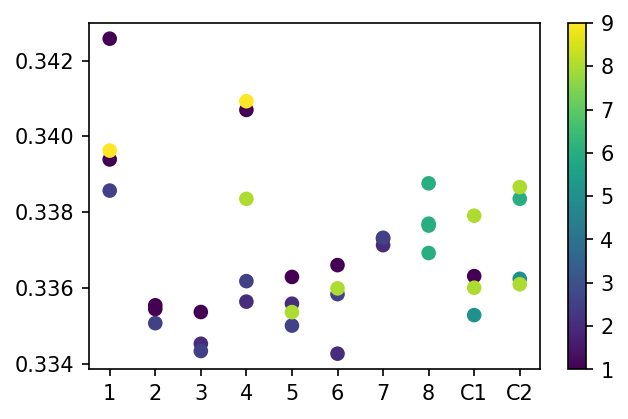

In [545]:
fig, ax = plt.subplots(1,1)

for i, s in enumerate(sam_alpha['sample'].unique()):
    sub = sam_alpha.loc[sam_alpha['sample'] == s]
    ma = ax.scatter([i] * sub.shape[0], sub[('Li_isotopes_alpha_LSVEC', 'solid')], c=sub[('Run', 'mean')], label=s, vmin=1, vmax=9)

fig.colorbar(ma)
ax.set_xticks(range(len(sam_alpha['sample'].unique())))
ax.set_xticklabels(sam_alpha['sample'].unique())

## Standardise to solution

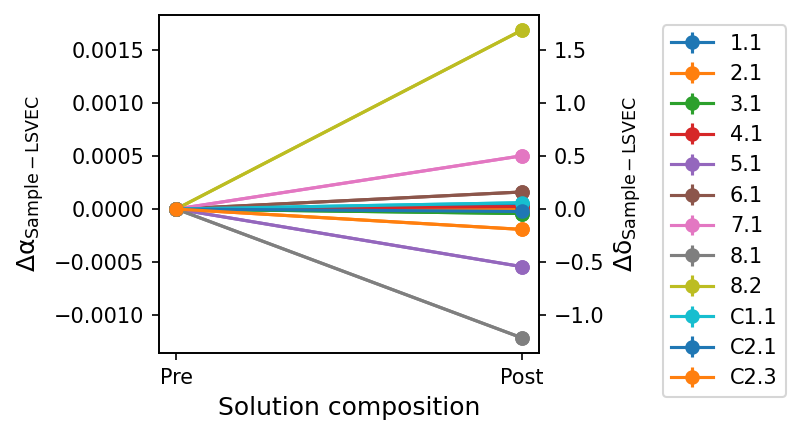

In [509]:
fig, aax = plt.subplots(1, 1)

dax = aax.twinx()

for k, r in solns.iterrows():
    alpha = r.loc['alpha_Sample-LSVEC']
    delta = r.loc['delta_Sample-LSVEC']
    aax.errorbar([0, 1], nom(alpha) - nom(alpha.pre), std(alpha), marker='o', label=k)
    dax.errorbar([0, 1], nom(delta) - nom(delta.pre), std(delta), marker='o', label=k)

aax.legend(bbox_to_anchor=(1.3, 1))

aax.set_ylabel('$\\Delta \\alpha_{Sample-LSVEC}$')
dax.set_ylabel('$\\Delta \\delta_{Sample-LSVEC}$')

aax.set_xticks([0, 1])
aax.set_xticklabels(['Pre', 'Post'])
aax.set_xlabel('Solution composition')

fig.tight_layout()

In [510]:
# split index into useful multiindex
solids.index = pd.MultiIndex.from_tuples([(c, r) for c, r in solids.index.str.split('.')], names=['condition', 'replicate'])
solns.index = pd.MultiIndex.from_tuples([(c, r) for c, r in solns.index.str.split('.')], names=['condition', 'replicate'])

In [511]:
# calculate means
solns.loc[:, ('alpha_Sample-LSVEC', 'mean')] = solns.loc[:, 'alpha_Sample-LSVEC'].values.mean(1)
solns.loc[:, ('delta_Sample-LSVEC', 'mean')] = solns.loc[:, 'delta_Sample-LSVEC'].values.mean(1)
solns.sort_index(level=1, inplace=True)

In [512]:
solids.loc[:, ('alpha_Sample-LSVEC', 'soln')] = solns.loc[:, ('alpha_Sample-LSVEC', 'mean')]

# fill missing values with mean of all others
# solids.loc[idx[:, '1'], ('alpha_Sample-LSVEC', 'soln')] = np.nanmean(solids.loc[idx[:, '1'], ('alpha_Sample-LSVEC', 'soln')])

# forward-fill solution values
solids.loc[:, ('alpha_Sample-LSVEC', 'soln')].ffill(inplace=True)

solids = solids.loc[['1', '2', '3', '4', 'C1', 'C2']]  # remove experiments without solution measurements

In [513]:
solids['alpha_Sample-Solution'] = solids[('alpha_Sample-LSVEC', 'mean')] / solids[('alpha_Sample-LSVEC', 'soln')]
solids['delta_Sample-Solution']  = (solids['alpha_Sample-Solution'] - 1) * 1000

## Uncertainty Sources Graph

In [514]:
from scipy import stats

In [515]:
# solids.apply(nom).to_csv('my_method.csv')

Text(0, 0.5, '$\\delta^7Li_{Sample-Fluid}$')

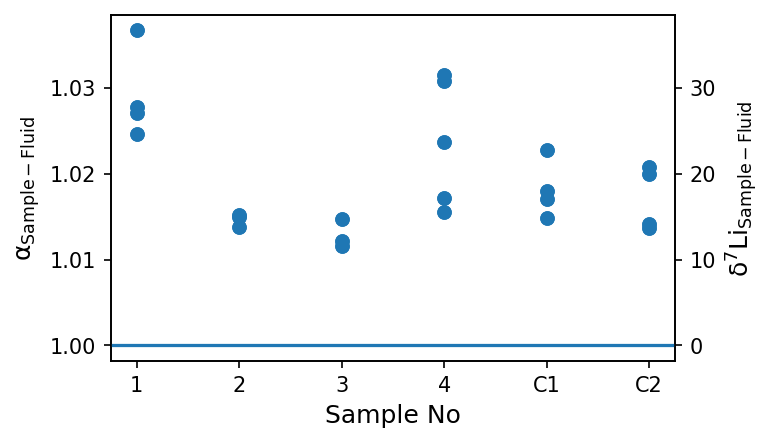

In [516]:
plt.errorbar(solids.index.get_level_values(0), nom(solids.loc[:, 'alpha_Sample-Solution']), std(solids.loc[:, 'alpha_Sample-Solution']), marker='o', lw=0, elinewidth=1)
plt.axhline(1)
plt.ylabel('$\\alpha_{Sample-Fluid}$')
plt.xlabel('Sample No')

ax2 = plt.gca().twinx()
ax2.errorbar(solids.index.get_level_values(0), nom(solids.loc[:, 'delta_Sample-Solution']), std(solids.loc[:, 'delta_Sample-Solution']), marker='o', lw=0, elinewidth=1)
ax2.axhline(0)
ax2.set_ylabel('$\\delta^7Li_{Sample-Fluid}$')

(-672.0, -654.0)

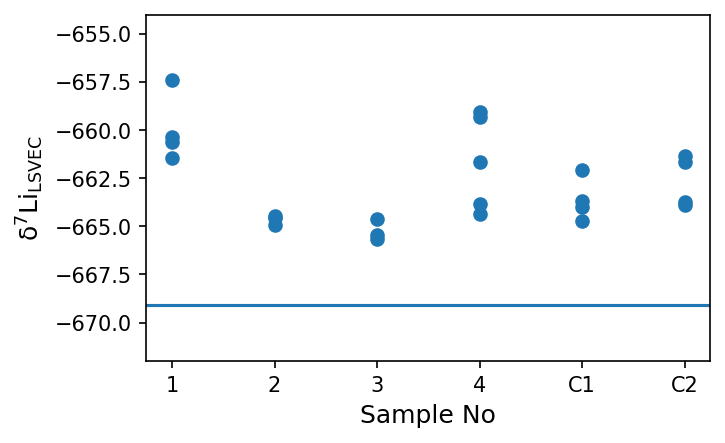

In [517]:
plt.errorbar(solids.index.get_level_values(0), nom(solids.loc[:, ('delta_Sample-LSVEC', 'mean')]), std(solids.loc[:, ('delta_Sample-LSVEC', 'mean')]), marker='o', lw=0, elinewidth=1)
plt.axhline(nom(np.mean(solns.loc[:, ('delta_Sample-LSVEC', 'mean')].values)))
plt.ylabel('$\\delta^7Li_{LSVEC}$')
plt.xlabel('Sample No')

plt.ylim(-672, -654)

<ErrorbarContainer object of 3 artists>

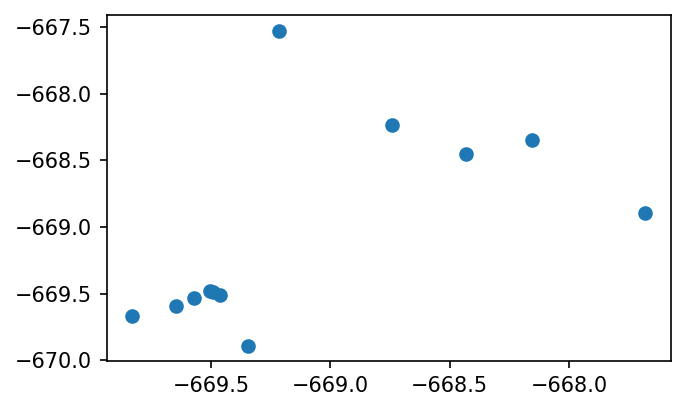

In [518]:
plt.errorbar(nom(solns.loc[:, ('delta_Sample-LSVEC', 'pre')]), nom(solns.loc[:, ('delta_Sample-LSVEC', 'post')]),
             xerr=std(solns.loc[:, ('delta_Sample-LSVEC', 'pre')]), yerr=std(solns.loc[:, ('delta_Sample-LSVEC', 'post')]),
             lw=0, elinewidth=2, marker='o')

<ErrorbarContainer object of 3 artists>

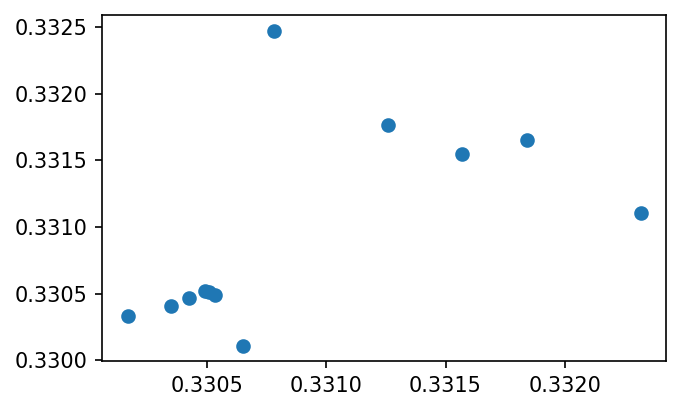

In [519]:
plt.errorbar(nom(solns.loc[:, ('alpha_Sample-LSVEC', 'pre')]), nom(solns.loc[:, ('alpha_Sample-LSVEC', 'post')]),
             xerr=std(solns.loc[:, ('alpha_Sample-LSVEC', 'pre')]), yerr=std(solns.loc[:, ('alpha_Sample-LSVEC', 'post')]),
             lw=0, elinewidth=2, marker='o')

In [520]:
np.mean(solns[('delta_Sample-LSVEC', 'pre')].values)

-669.0905424350716

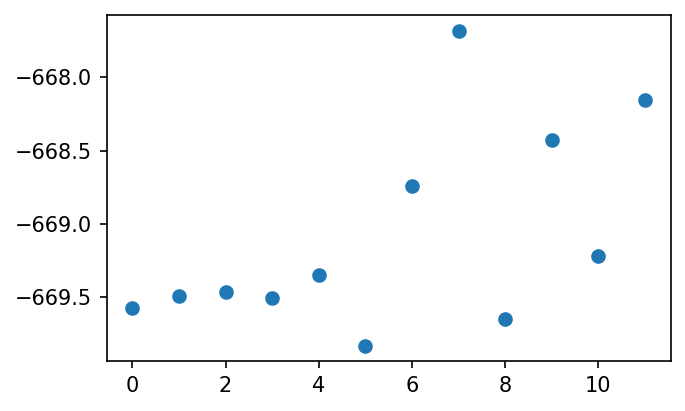

In [521]:
plt.scatter(np.arange(solns.shape[0]), nom(solns[('delta_Sample-LSVEC', 'pre')]))